In [2]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Fri Sep 16 16:36:01 2022
Driver Version                            : 510.54
CUDA Version                              : 11.6

Attached GPUs                             : 1
GPU 00000000:08:00.0
    Product Name                          : NVIDIA GeForce GTX 1080
    Product Brand                         : GeForce
    Product Architecture                  : Pascal
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : N/A
    GPU UUID         

In [3]:
import math
import logging
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.data import Batch
from torch_geometric.loader import DataListLoader
from torch_geometric.nn import MaskLabel, TransformerConv
from torch_geometric.utils import index_to_mask

import sys
sys.path.insert(0, '..')  #go up one directory
from src.data.jetnet_graph import JetNetGraph
from src.models.unimp_model import UniMP
from custom_libraries.my_functions import *
from focal_loss import FocalLoss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

logging.basicConfig(level=logging.INFO)

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
def train(model, loader, optimizer, label_rate=0.85, loss_fcn=F.cross_entropy):
    model.train()

    sum_loss = 0
    sum_true = 0
    sum_all = 0
    for i, data in enumerate(loader):
        optimizer.zero_grad()

        train_mask = torch.ones_like(data.x[:, 0], dtype=torch.bool)
        propagation_mask = MaskLabel.ratio_mask(train_mask, ratio=label_rate)
        supervision_mask = train_mask ^ propagation_mask

        data = data.cuda()
        out = model(data.x, data.y, data.edge_index, propagation_mask)
        loss = loss_fcn(out[supervision_mask], data.y[supervision_mask])
        loss.backward()
        sum_loss += float(loss)
        optimizer.step()

        pred = out[supervision_mask].argmax(dim=-1)
        sum_true += int((pred == data.y[supervision_mask]).sum())
        sum_all += pred.size(0)
        logging.info(f"Batch: {i + 1:03d}, Train Loss: {sum_loss:.4f}")

    return float(sum_loss) / (i + 1), float(sum_true) / sum_all

In [50]:
@torch.no_grad()
def test(model, loader, label_rate=0.85, output_pred=False):
    model.eval()

    sum_true = 0
    sum_all = 0
    for data in loader:
        data = data.cuda()
        test_mask = torch.ones_like(data.x[:, 0], dtype=torch.bool)
        propagation_mask = MaskLabel.ratio_mask(test_mask, ratio=label_rate)
        supervision_mask = test_mask ^ propagation_mask

        out = model(data.x, data.y, data.edge_index, propagation_mask)
        pred = out[supervision_mask].argmax(dim=-1)
        sum_true += int((pred == data.y[supervision_mask]).sum())
        sum_all += pred.size(0)
    if output_pred:
        return out, pred, float(sum_true) / sum_all, test_mask, propagation_mask, supervision_mask
    else:
        return float(sum_true) / sum_all


def collate_fn(items):
    sum_list = sum(items, [])
    return Batch.from_data_list(sum_list)

In [6]:
def reset_params(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            print(layer)
            layer.reset_parameters()
        else:
            for sublayer in layer:
                if hasattr(sublayer, 'reset_parameters'):
                    print(sublayer)
                    sublayer.reset_parameters()

In [7]:
# train_root = osp.join(osp.dirname(osp.realpath(__file__)), "..", "..", "data", "train")
# val_root = osp.join(osp.dirname(osp.realpath(__file__)), "..", "..", "data", "val")
train_root = "/ssl-jet-vol/semi-supervised-tests/Jupyter/data/train"
val_root = "/ssl-jet-vol/semi-supervised-tests/Jupyter/data/val"
max_jets = 1000
train_dataset = JetNetGraph(train_root, max_jets=max_jets, file_start=0, file_stop=1)
val_dataset = JetNetGraph(val_root, max_jets=max_jets, file_start=1, file_stop=2)
batch_size = 1  #1k jets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_loader = DataListLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate_fn
val_loader = DataListLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
val_loader.collate_fn = collate_fn

model = UniMP(
    in_channels=train_dataset.num_features,
    num_classes=train_dataset.num_classes,
    hidden_channels=64,
    num_layers=3,
    heads=2,
).to(device)

logging.info("Model summary")
logging.info(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

cuda


INFO:root:Model summary
INFO:root:UniMP(
  (label_emb): MaskLabel()
  (convs): ModuleList(
    (0): TransformerConv(3, 32, heads=2)
    (1): TransformerConv(64, 32, heads=2)
    (2): TransformerConv(64, 5, heads=2)
  )
  (norms): ModuleList(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
)


In [8]:
reset_params(model)
num_epochs = 100
train_loss_lst, val_acc_lst, train_acc_lst = [], [], []

# Set up Focal loss
gamma = 1
floss = FocalLoss(gamma=gamma, reduction='mean')

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fcn=floss)
    val_acc = test(model, val_loader)
    logging.info(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_acc_lst.append(val_acc)

MaskLabel()
TransformerConv(3, 32, heads=2)
TransformerConv(64, 32, heads=2)
TransformerConv(64, 5, heads=2)
LayerNorm((64,), eps=1e-05, elementwise_affine=True)
LayerNorm((64,), eps=1e-05, elementwise_affine=True)


INFO:root:Batch: 001, Train Loss: 1.2941
INFO:root:Epoch: 001, Train Loss: 1.2941, Train Acc: 0.3160, Val Acc: 0.4674
INFO:root:Batch: 001, Train Loss: 1.1688
INFO:root:Epoch: 002, Train Loss: 1.1688, Train Acc: 0.4690, Val Acc: 0.4869
INFO:root:Batch: 001, Train Loss: 1.0685
INFO:root:Epoch: 003, Train Loss: 1.0685, Train Acc: 0.4913, Val Acc: 0.4868
INFO:root:Batch: 001, Train Loss: 0.9970
INFO:root:Epoch: 004, Train Loss: 0.9970, Train Acc: 0.4791, Val Acc: 0.4860
INFO:root:Batch: 001, Train Loss: 0.9370
INFO:root:Epoch: 005, Train Loss: 0.9370, Train Acc: 0.4740, Val Acc: 0.4872
INFO:root:Batch: 001, Train Loss: 0.8827
INFO:root:Epoch: 006, Train Loss: 0.8827, Train Acc: 0.4744, Val Acc: 0.4777
INFO:root:Batch: 001, Train Loss: 0.8336
INFO:root:Epoch: 007, Train Loss: 0.8336, Train Acc: 0.4845, Val Acc: 0.4885
INFO:root:Batch: 001, Train Loss: 0.7956
INFO:root:Epoch: 008, Train Loss: 0.7956, Train Acc: 0.4776, Val Acc: 0.4816
INFO:root:Batch: 001, Train Loss: 0.7563
INFO:root:Epoch

INFO:root:Batch: 001, Train Loss: 0.4376
INFO:root:Epoch: 071, Train Loss: 0.4376, Train Acc: 0.5841, Val Acc: 0.5907
INFO:root:Batch: 001, Train Loss: 0.4344
INFO:root:Epoch: 072, Train Loss: 0.4344, Train Acc: 0.5890, Val Acc: 0.5852
INFO:root:Batch: 001, Train Loss: 0.4368
INFO:root:Epoch: 073, Train Loss: 0.4368, Train Acc: 0.5845, Val Acc: 0.5812
INFO:root:Batch: 001, Train Loss: 0.4295
INFO:root:Epoch: 074, Train Loss: 0.4295, Train Acc: 0.5924, Val Acc: 0.5885
INFO:root:Batch: 001, Train Loss: 0.4309
INFO:root:Epoch: 075, Train Loss: 0.4309, Train Acc: 0.5941, Val Acc: 0.5773
INFO:root:Batch: 001, Train Loss: 0.4302
INFO:root:Epoch: 076, Train Loss: 0.4302, Train Acc: 0.5802, Val Acc: 0.5853
INFO:root:Batch: 001, Train Loss: 0.4439
INFO:root:Epoch: 077, Train Loss: 0.4439, Train Acc: 0.5781, Val Acc: 0.5848
INFO:root:Batch: 001, Train Loss: 0.4370
INFO:root:Epoch: 078, Train Loss: 0.4370, Train Acc: 0.5801, Val Acc: 0.5901
INFO:root:Batch: 001, Train Loss: 0.4274
INFO:root:Epoch

In [57]:
reset_params(model)
num_epochs = 100
train_loss_lst, val_acc_lst, train_acc_lst = [], [], []

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_acc = test(model, val_loader)
    logging.info(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_acc_lst.append(val_acc)

MaskLabel()
TransformerConv(3, 32, heads=2)
TransformerConv(64, 32, heads=2)
TransformerConv(64, 5, heads=2)
LayerNorm((64,), eps=1e-05, elementwise_affine=True)
LayerNorm((64,), eps=1e-05, elementwise_affine=True)


INFO:root:Batch: 001, Train Loss: 1.4293
INFO:root:Epoch: 001, Train Loss: 1.4293, Train Acc: 0.4773, Val Acc: 0.4795
INFO:root:Batch: 001, Train Loss: 1.3707
INFO:root:Epoch: 002, Train Loss: 1.3707, Train Acc: 0.4694, Val Acc: 0.4887
INFO:root:Batch: 001, Train Loss: 1.2927
INFO:root:Epoch: 003, Train Loss: 1.2927, Train Acc: 0.4740, Val Acc: 0.4769
INFO:root:Batch: 001, Train Loss: 1.2211
INFO:root:Epoch: 004, Train Loss: 1.2211, Train Acc: 0.4805, Val Acc: 0.4871
INFO:root:Batch: 001, Train Loss: 1.1544
INFO:root:Epoch: 005, Train Loss: 1.1544, Train Acc: 0.4834, Val Acc: 0.4848
INFO:root:Batch: 001, Train Loss: 1.1023
INFO:root:Epoch: 006, Train Loss: 1.1023, Train Acc: 0.4710, Val Acc: 0.4901
INFO:root:Batch: 001, Train Loss: 1.0661
INFO:root:Epoch: 007, Train Loss: 1.0661, Train Acc: 0.4734, Val Acc: 0.4782
INFO:root:Batch: 001, Train Loss: 1.0370
INFO:root:Epoch: 008, Train Loss: 1.0370, Train Acc: 0.4813, Val Acc: 0.4841
INFO:root:Batch: 001, Train Loss: 1.0187
INFO:root:Epoch

INFO:root:Batch: 001, Train Loss: 0.8721
INFO:root:Epoch: 071, Train Loss: 0.8721, Train Acc: 0.5796, Val Acc: 0.5846
INFO:root:Batch: 001, Train Loss: 0.8681
INFO:root:Epoch: 072, Train Loss: 0.8681, Train Acc: 0.5836, Val Acc: 0.5894
INFO:root:Batch: 001, Train Loss: 0.8778
INFO:root:Epoch: 073, Train Loss: 0.8778, Train Acc: 0.5796, Val Acc: 0.5722
INFO:root:Batch: 001, Train Loss: 0.8830
INFO:root:Epoch: 074, Train Loss: 0.8830, Train Acc: 0.5813, Val Acc: 0.5875
INFO:root:Batch: 001, Train Loss: 0.8787
INFO:root:Epoch: 075, Train Loss: 0.8787, Train Acc: 0.5736, Val Acc: 0.5893
INFO:root:Batch: 001, Train Loss: 0.8849
INFO:root:Epoch: 076, Train Loss: 0.8849, Train Acc: 0.5778, Val Acc: 0.5894
INFO:root:Batch: 001, Train Loss: 0.8661
INFO:root:Epoch: 077, Train Loss: 0.8661, Train Acc: 0.5841, Val Acc: 0.5792
INFO:root:Batch: 001, Train Loss: 0.8631
INFO:root:Epoch: 078, Train Loss: 0.8631, Train Acc: 0.5811, Val Acc: 0.5672
INFO:root:Batch: 001, Train Loss: 0.8662
INFO:root:Epoch

### Question: why is this constant for any max_jets
Need to delete the .pt files in the "processed" folder

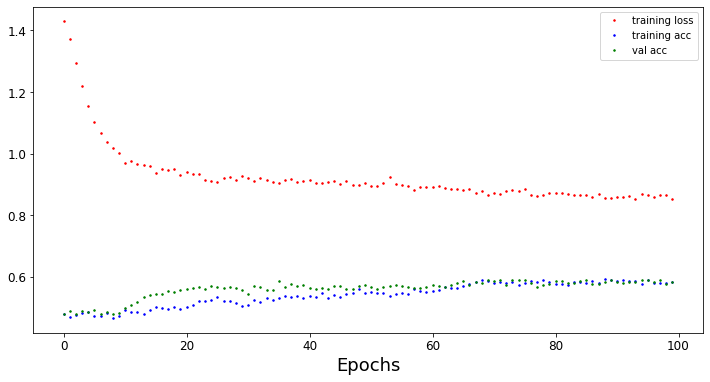

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
marker_size = 3
plt.plot(train_loss_lst, "r.", markersize=marker_size, label="training loss")
plt.plot(train_acc_lst, "b.", markersize=marker_size, label="training acc")
plt.plot(val_acc_lst, "g.",markersize=marker_size, label="val acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

### Obtain predicted probabilities

In [60]:
out, pred, test_acc, test_mask, propagation_mask, supervision_mask = test(model, val_loader, output_pred=True)
m = torch.nn.Softmax(dim=1)
out_norm = m(out)  # the predicted probabilities

In [61]:
0 in pred

False

In [62]:
1 in pred

False

In [63]:
2 in pred

True

In [64]:
3 in pred

True

In [65]:
4 in pred

False

The 5 cells above shows that the model ONLY predicted classes 2 (photon) and classes 3 (charged_hadron)

### Plot class balance
PDG_CLASSES = ["electron", "muon", "photon", "charged_hadron", "neutral_hadron"]

0


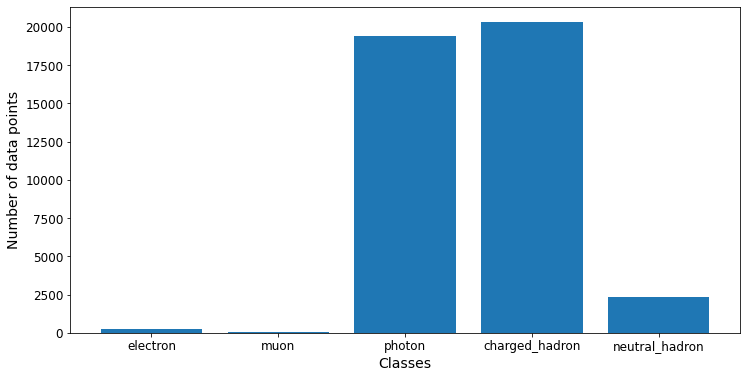

In [66]:
classes = np.array([i for i in range(5)])
PDG_CLASSES = ["electron", "muon", "photon", "charged_hadron", "neutral_hadron"]
for i, data in enumerate(train_loader):
    data = data.cuda()
    train_mask = torch.ones_like(data.x[:, 0], dtype=torch.bool)
    print(i)
    if i == 0:
        labels_training = data.y[train_mask].cpu().numpy()
    else:
        labels_training = np.concatenate(labels_training, data.y[train_mask].cpu().numpy()) 
    
class_dict = plot_class_balance(classes, labels_training, PDG_CLASSES)

In [67]:
labels_training.shape

(42323,)

In [68]:
sum(list(class_dict.values()))

42323

### Plot accuracy for each class

0
pred: torch.Size([6381])
labels: (6381,)
{0: [43, 0], 1: [3, 0], 2: [2926, 1760], 3: [3066, 1997], 4: [343, 0]}


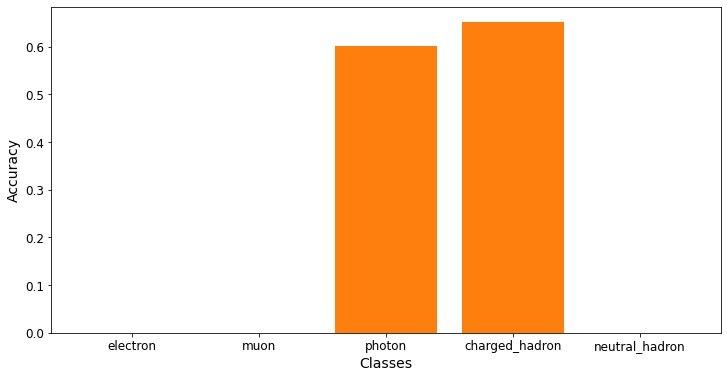

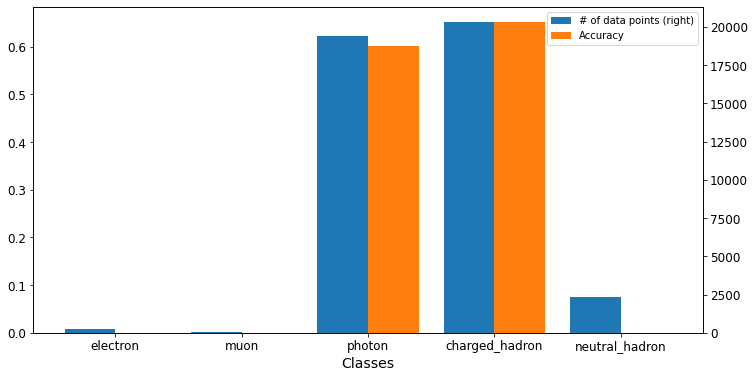

In [69]:
for i, data in enumerate(val_loader):
    data = data.cuda()
    print(i)
    if i == 0:
        labels_val = data.y[supervision_mask].cpu().numpy()
    else:
        labels_val = np.concatenate(labels_val, data.y[supervision_mask].cpu().numpy()) 
    print(f"pred: {pred.shape}")
    print(f"labels: {labels_val.shape}")
plot_class_balance_and_accuracy(class_dict, labels_val, PDG_CLASSES, pred)

### ROC Curve OvR for Muon

0.5810979867333876


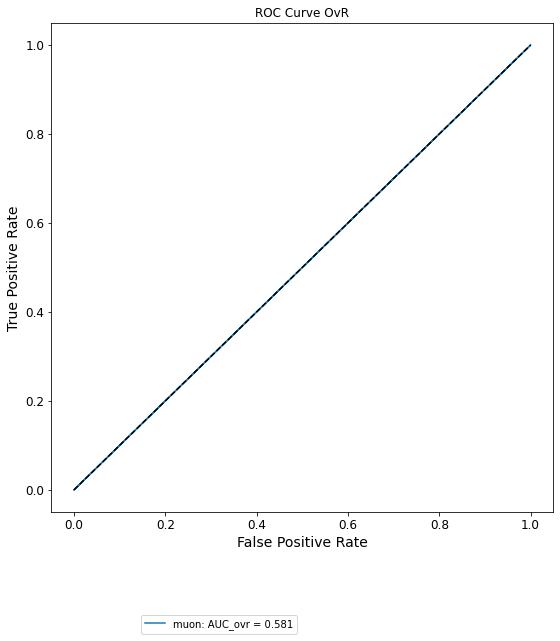

In [70]:
classes = [1]
class_labels = ["muon"]
roc_auc_ovr = plot_overlayed_roc_curve(classes, data.y[test_mask], out_norm[test_mask][:, classes], class_labels, ncol=1)

0
0.46648397510438294
0.5810979867333876
0.7376530919780642
0.6796390863672189
0.7569667548864373


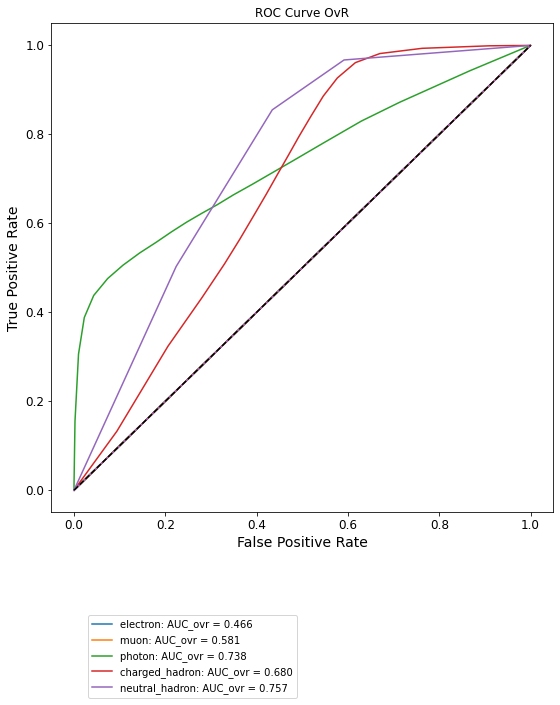

In [71]:
classes = np.array([i for i in range(5)])
for i, data in enumerate(val_loader):
    data = data.cuda()
    print(i)
    if i == 0:
        labels_test = data.y[test_mask].cpu()
    else:
        labels_test = np.concatenate(labels_test, data.y[test_mask].cpu()) 
        #TODO: either bring back .numpy() or figure out how to concat tensors
roc_auc_ovr = plot_overlayed_roc_curve(classes, labels_test, out_norm[test_mask][:, classes], PDG_CLASSES, ncol=1)

0.7376530919780642
0.6796390863672189


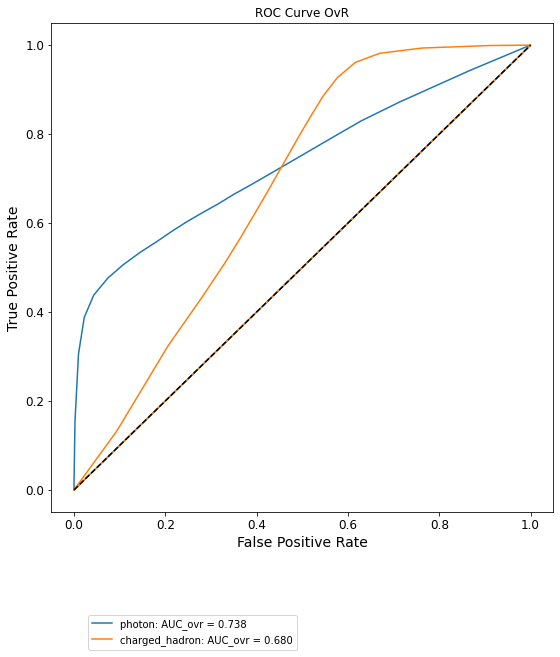

{2: 0.7376530919780642, 3: 0.6796390863672189}

In [72]:
classes = [2, 3]
class_labels = ["photon", "charged_hadron"]
plot_overlayed_roc_curve(classes, labels_test, out_norm[test_mask][:, classes], class_labels, ncol=1)

In [73]:
# import seaborn as sns
# from scipy import stats
# def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
#     '''
#     Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
#     Args:
#         tpr: The list of TPRs representing each coordinate.
#         fpr: The list of FPRs representing each coordinate.
#         scatter: When True, the points used on the calculation will be plotted with the line (default = True).
#     '''
#     if ax == None:
#         plt.figure(figsize = (5, 5))
#         ax = plt.axes()
    
#     if scatter:
#         sns.scatterplot(x = fpr, y = tpr, ax = ax)
#     sns.lineplot(x = fpr, y = tpr, ax = ax)
#     sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-0.05, 1.05)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")

In [74]:
# # Plots the ROC Curves One vs Rest
# plt.figure(figsize = (12, 3))
# roc_auc_ovr = {}
# predictions = out_norm[test_mask]
# for i in range(len(classes)):  #for each of the classes
#     # Gets the class
#     c = classes[i]
#     y_real = [1 if y == c else 0 for y in labels_testing]
#     y_proba = predictions[:, i]
#     tpr, fpr = get_all_roc_coordinates(y_real, y_proba.cpu())
    
#     # Calculates the ROC Coordinates and plots the ROC Curves
#     ax_bottom = plt.subplot(1, 5, i+1)
#     plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
#     ax_bottom.set_title(f"ROC OvR {PDG_CLASSES[i]}")
    
#     # Calculates the ROC AUC OvR
#     roc_auc_ovr[c] = roc_auc_score(y_real, y_proba.detach().cpu())
    
# plt.tight_layout()

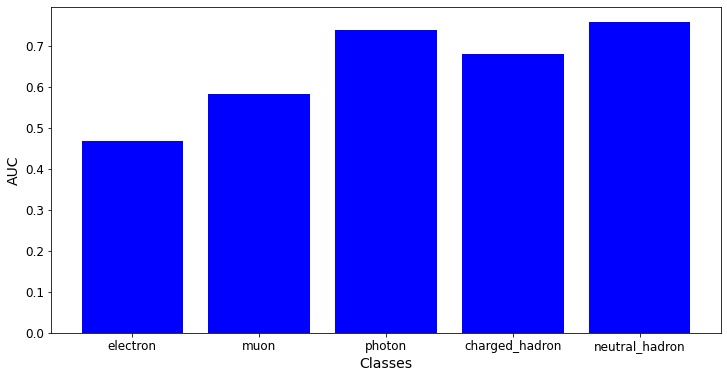

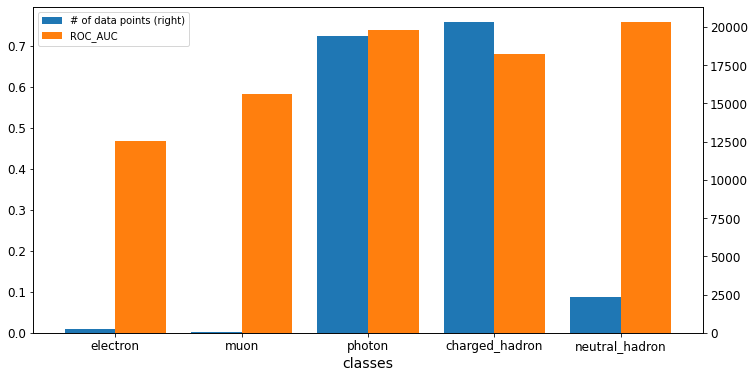

In [75]:
plot_class_balance_and_AUC(class_dict, roc_auc_ovr, PDG_CLASSES)